In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [26]:
# Read in the data & check the size
airlines = pd.read_csv('output.csv')
airlines.shape

(100, 5)

In [27]:
#check the head of the data
airlines.head()

,Post ID,Score,Title,Body,Sentiment Analysis Result
0,12cjf5q,296,I flew Norse into JFK and they let us off the ...,We got off at terminal 7 and instead of going ...,negative
1,133bh0h,157,Frontier Baggage Scam,Literally saw something I have never seen in a...,negative
2,10bx7c4,139,Small Claims Court is Great for Air Travel Dis...,"Hi everyone, recently I flew Turkish to Ethiop...",negative
3,f0qq9o,116,Just Had an Older Woman Try to Take My Seat,In India on Airline Indigo. I see a middle-age...,negative
4,buwy6x,108,What's your best not-a-tip when flying?,I'm mostly a lurker here but it seems we get a...,neutral


In [28]:
#totalling the sentiment analysis results
sent_summary = airlines['Sentiment Analysis Result'].value_counts()
sent_summary

neutral     53
negative    42
positive     5
Name: Sentiment Analysis Result, dtype: int64

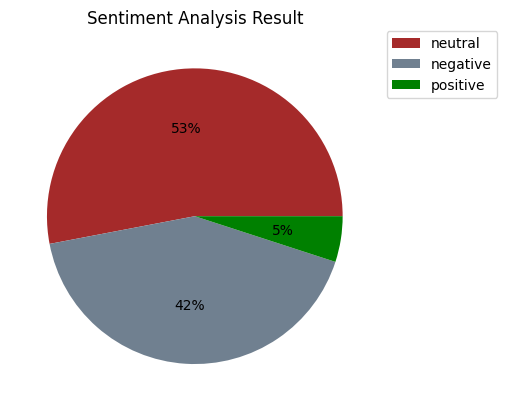

In [29]:
#compiling the results into a pie chart
colors = ['brown', 'slategray', 'green']
ax = sent_summary.plot(kind='pie', y='Score',autopct='%1.0f%%', 
                       colors = colors, ylabel='', labeldistance=None)
ax.set_title('Sentiment Analysis Result')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

## Performing LDA

In [30]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Changing series to list and replacing NaN with empty strings
air_list = airlines['Body'].fillna('').to_list()

# Fit and Transform the documents
train_data = tfidf.fit_transform(air_list) 

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [31]:
# Define the number of topics or components
num_components=7

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [32]:
# Print the topics with their terms
feature_names = tfidf.get_feature_names_out()

for index, component in enumerate(lda_components):
    zipped = zip(feature_names, component)
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:7]
    top_terms_list = list(dict(top_terms_key).keys())
    print("Topic " + str(index) + ": ", top_terms_list)

Topic 0:  ['like', 'canada', 'dubai', 'pass', 'jeddah', 'test', 'fees']
Topic 1:  ['baggage', 'aa', 'going', 'kids', 'customs', 'icelandair', '3']
Topic 2:  ['credit', 'norse', 'good', 'baggage', 'row', 'taxes', 'loud']
Topic 3:  ['turkish', 'gt', 'card', 'visa', 'note', 'member', 'klm']
Topic 4:  ['lhr', 'edreams', 'klm', 'voucher', 'went', 'jetstar', 'mobility']
Topic 5:  ['prague', 'july', 'flights', 'level', 'sign', 'bus', 'https']
Topic 6:  ['flight', 't', 's', 'told', 'ticket', 'gate', 'seat']
